### MEMO
- TODO
  - TGを「男性向けメールを送信する」，CGを「女性向けメールを送信する」にしてみる
  - 予測モデルをいじる
  - EconMLつかってみる

### Import

In [87]:
import urllib.request
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

plt.style.use("ggplot")
from operator import itemgetter

### Data
- dataset from "The MineThatData E-Mail Analytics And Data Mining Challenge"
- 実験対象者
  - 過去12か月に購買履歴のある顧客
- 介入（segment）
  - 男性向けメールを送る（Mens E-Mail）
  - 女性向けメールを送る（Womens E-Mail）
  - メールを送らない（No E-Mail）
- 目的変数
  - メール受信後2週間以内にサイトに訪問したか否か（visit ∈ {0, 1}）
  - メール受信後2週間以内に商品を購入したか否か（conversion ∈ {0, 1}）
  - メール受信後2週間以内の購入金額（spend）
- 特徴量
  - 最後に商品を買ってからの経過月数（recency）
  - 過去一年に費やされた実際の購買金額（history）
  - 過去一年に男性向け商品を買ったか否か（mens）
  - 過去一年に女性向け商品を買ったか否か（womens）
  - 過去12か月以内の新規顧客であるか否か（newbie）
  - 居住地（zip_code ∈ {Urban, Suburban, Rural}）
  - 過去1年に購買したチャネル（channel ∈ {Phone, Web, Multichannel}）

#### 読込

In [2]:
# path
csv_url = "http://www.minethatdata.com/Kevin_Hillstrom_MineThatData_E-MailAnalytics_DataMiningChallenge_2008.03.20.csv"
csv_filename = "source_data.csv"

# read
with open(csv_filename, "w") as fp:
    data = urllib.request.urlopen(csv_url).read()
    fp.write(data.decode("ascii"))

In [4]:
# データ確認
source_df = pd.read_csv(csv_filename)
source_df.head()

,recency,history_segment,history,mens,womens,zip_code,newbie,channel,segment,visit,conversion,spend
0,10,2) $100 - $200,142.44,1,0,Surburban,0,Phone,Womens E-Mail,0,0,0.0
1,6,3) $200 - $350,329.08,1,1,Rural,1,Web,No E-Mail,0,0,0.0
2,7,2) $100 - $200,180.65,0,1,Surburban,1,Web,Womens E-Mail,0,0,0.0
3,9,5) $500 - $750,675.83,1,0,Rural,1,Web,Mens E-Mail,0,0,0.0
4,2,1) $0 - $100,45.34,1,0,Urban,0,Web,Womens E-Mail,0,0,0.0


#### 加工
- TGを「男性向けメールを送信された顧客」，CGを「何も送信されていない顧客」とする

In [8]:
mailed_df = source_df[source_df["segment"] != "Womens E-Mail"].reset_index(drop=True)
mailed_df.head()

,recency,history_segment,history,mens,womens,zip_code,newbie,channel,segment,visit,conversion,spend
0,6,3) $200 - $350,329.08,1,1,Rural,1,Web,No E-Mail,0,0,0.0
1,9,5) $500 - $750,675.83,1,0,Rural,1,Web,Mens E-Mail,0,0,0.0
2,9,5) $500 - $750,675.07,1,1,Rural,1,Phone,Mens E-Mail,0,0,0.0
3,2,2) $100 - $200,101.64,0,1,Urban,0,Web,Mens E-Mail,1,0,0.0
4,4,3) $200 - $350,241.42,0,1,Rural,1,Multichannel,No E-Mail,0,0,0.0


In [21]:
# zip_codeとchannelをダミー変数に変換
dummied_df = pd.get_dummies(
    mailed_df[["zip_code", "channel"]], drop_first=True, dtype="uint8"
)
mailed_df_dummies = mailed_df.drop(
    [
        "history_segment",
        "zip_code",
        "channel",
        "visit",
        "conversion",
        "spend",
    ],
    axis=1,
).join(dummied_df)
mailed_df_dummies.head()

,recency,history,mens,womens,newbie,segment,zip_code_Surburban,zip_code_Urban,channel_Phone,channel_Web
0,6,329.08,1,1,1,No E-Mail,0,0,0,1
1,9,675.83,1,0,1,Mens E-Mail,0,0,0,1
2,9,675.07,1,1,1,Mens E-Mail,0,0,1,0
3,2,101.64,0,1,0,Mens E-Mail,0,1,0,1
4,4,241.42,0,1,1,No E-Mail,0,0,0,0


In [29]:
# TGとCGそれぞれの人数
mailed_df_dummies.groupby("segment").size()

segment
Mens E-Mail    21307
No E-Mail      21306
dtype: int64

In [22]:
# TGとCGで各特徴量の平均値が近しいか（ランダムな割当になっているか）
mailed_df_dummies.groupby("segment").mean()

,recency,history,mens,womens,newbie,zip_code_Surburban,zip_code_Urban,channel_Phone,channel_Web
segment,,,,,,,,,
Mens E-Mail,5.773642,242.835931,0.550946,0.551415,0.501525,0.445910,0.401887,0.433660,0.445394
No E-Mail,5.749695,240.882653,0.553224,0.547639,0.501971,0.451751,0.400920,0.437764,0.439923


In [23]:
# 特徴量行列
feature_vector_df = mailed_df.drop(
    [
        "history_segment",
        "zip_code",
        "channel",
        "segment",
        "visit",
        "conversion",
        "spend",
    ],
    axis=1,
)
feature_vector_df = feature_vector_df.join(dummied_df)
feature_vector_df.head()

,recency,history,mens,womens,newbie,zip_code_Surburban,zip_code_Urban,channel_Phone,channel_Web
0,6,329.08,1,1,1,0,0,0,1
1,9,675.83,1,0,1,0,0,0,1
2,9,675.07,1,1,1,0,0,1,0
3,2,101.64,0,1,0,0,1,0,1
4,4,241.42,0,1,1,0,0,0,0


In [26]:
# 介入変数/目的変数
is_treat_list = list(
    mailed_df["segment"] == "Mens E-Mail"
)  # 男性向けメールを送信されたか否か
is_cv_list = list(mailed_df["visit"] == 1)  # CV（＝サイト訪問）したか否か

### Model構築＆学習
- Two-Model approach
  - TGとCGそれぞれで予測モデルを構築
  - 予測値の差分をCATE推定値とする

#### Train-Test Split

In [35]:
# 学習/テストデータに分割
(
    # 目的変数
    train_is_cv_list,
    test_is_cv_list,
    # 介入変数
    train_is_treat_list,
    test_is_treat_list,
    # 特徴量行列
    train_feature_vector_df,
    test_feature_vector_df,
) = train_test_split(
    is_cv_list, is_treat_list, feature_vector_df, test_size=0.5, random_state=42
)

In [55]:
# indexリセット
train_feature_vector_df = train_feature_vector_df.reset_index(drop=True)
test_feature_vector_df = test_feature_vector_df.reset_index(drop=True)

#### TG/CGモデル用学習データ作成

In [72]:
# 学習データサイズ
train_sample_num = len(train_is_cv_list)

# 学習データ（目的変数/特徴量行列）をTG用とCG用に振り分ける

# TGモデル用データ
treat_is_cv_list = [
    train_is_cv_list[i]
    for i in range(train_sample_num)
    if train_is_treat_list[i] == True
]
treat_feature_vector_list = train_feature_vector_df[train_is_treat_list]
# CGモデル用データ
control_is_cv_list = [
    train_is_cv_list[i]
    for i in range(train_sample_num)
    if train_is_treat_list[i] == False
]
control_feature_vector_list = train_feature_vector_df[
    list(map(lambda a: a == False, train_is_treat_list))
]

#### 学習
- logistic regression

In [77]:
# インスタンス
treat_model = LogisticRegression(C=0.01, random_state=1, max_iter=1000)
control_model = LogisticRegression(C=0.01, random_state=1, max_iter=1000)

# 学習
treat_model.fit(treat_feature_vector_list, treat_is_cv_list)
control_model.fit(control_feature_vector_list, control_is_cv_list)

LogisticRegression(C=0.01, max_iter=1000, random_state=1)

### Uplift scoreを算出
- テストデータの各サンプルに対し，TG/CGモデルそれぞれの予測値を得る
- Uplift score = TGモデルの予測値 / CGモデルの予測値とする

In [85]:
# 予測値（予測CVR）を取得
treat_score = treat_model.predict_proba(test_feature_vector_df)
control_score = control_model.predict_proba(test_feature_vector_df)

# Uplift score
score_list = treat_score[:, 1] / control_score[:, 1]

### 評価

#### Uplift scoreのパーセンタイル毎の（実際の）CVR

In [110]:
# uplift scoreを降順に並べ替える
result = list(zip(test_is_cv_list, test_is_treat_list, score_list))
result.sort(key=itemgetter(2), reverse=True)

In [121]:
# 可視化用データフレーム
qdf = pd.DataFrame(columns=("treat_cvr", "control_cvr"))

# TG/CGそれぞれについて，uplift scoreの10パーセンタイルごとにCVRを算出
for n in range(10):

    # resultを10パーセンタイルごとに切断
    start = int(n * len(result) / 10)
    end = int((n + 1) * len(result) / 10) - 1
    quantiled_result = result[start:end]

    # quantiled_resultにおけるTGとCGの人数をカウント
    treat_uu = list(map(lambda item: item[1], quantiled_result)).count(
        True
    )  # TGか否かの列のみ抽出し，True（=TG）の数をカウント
    control_uu = list(map(lambda item: item[1], quantiled_result)).count(
        False
    )  # TGか否かの列のみ抽出し，False（=CG）の数をカウント

    # quantiled_resultにおけるTGとCGのCV数をカウント
    treat_cv = [item[0] for item in quantiled_result if item[1] is True].count(True)
    control_cv = [item[0] for item in quantiled_result if item[1] is False].count(True)

    # quantiled_resultにおけるTGとCGのCVRを算出
    treat_cvr = treat_cv / treat_uu
    control_cvr = control_cv / control_uu

    # 可視化用データフレーム
    label = "{}%~{}%".format(n * 10, (n + 1) * 10)
    qdf.loc[label] = [treat_cvr, control_cvr]
qdf

,treat_cvr,control_cvr
0%~10%,0.104167,0.040976
10%~20%,0.140952,0.061111
20%~30%,0.164319,0.079812
30%~40%,0.157509,0.106075
40%~50%,0.162524,0.111624
50%~60%,0.194291,0.120690
60%~70%,0.211575,0.119070
70%~80%,0.234906,0.122430
80%~90%,0.248360,0.150517
90%~100%,0.257036,0.169173


Text(0, 0.5, 'CVR')

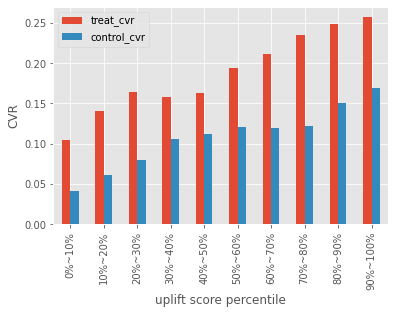

In [122]:
# 可視化
# この図だと「どのuplift scoreの顧客に対しても，メール送信しないよりは男性メールを送信した方がよい」という結果
qdf.plot.bar()
plt.xlabel("uplift score percentile")
plt.ylabel("CVR")

#### Uplift curveとAUUC
- AUUC: Area Under the Uplift Curve

In [127]:
treat_uu = 0
control_uu = 0
treat_cv = 0
control_cv = 0
treat_cvr = 0.0
control_cvr = 0.0
lift = 0

stat_data = []

# uplift scoreの降順に見ていく
for is_cv, is_treat, score in result:

    # 見たところまでのTG/CGそれぞれにおけるCVRを算出
    # TGである場合
    if is_treat:
        treat_uu += 1
        if is_cv:
            treat_cv += 1
        treat_cvr = treat_cv / treat_uu
    # CGである場合
    else:
        control_uu += 1
        if is_cv:
            control_cv += 1
        control_cvr = control_cv / control_uu

    # TGとCGのCVRの差にTGの人数を乗算することでlift（＝CVした人数の増分）を算出
    lift = (treat_cvr - control_cvr) * treat_uu

    # データを格納
    stat_data.append(
        [
            is_cv,
            is_treat,
            score,
            treat_uu,
            control_uu,
            treat_cv,
            control_cv,
            treat_cvr,
            control_cvr,
            lift,
        ]
    )

# stat_dataをデータフレームに変換
df = pd.DataFrame(stat_data)
df.columns = [
    "is_cv",
    "is_treat",
    "score",
    "treat_uu",
    "control_uu",
    "treat_cv",
    "control_cv",
    "treat_cvr",
    "control_cvr",
    "lift",
]

# ベースライン値を追加
df["base_line"] = df.index * df["lift"][len(df.index) - 1] / len(df.index)
df

,is_cv,is_treat,score,treat_uu,control_uu,treat_cv,control_cv,treat_cvr,control_cvr,lift,base_line
0,False,True,2.945297,1,0,0,0,0.000000,0.000000,0.000000,0.000000
1,False,True,2.927187,2,0,0,0,0.000000,0.000000,0.000000,0.039564
2,False,False,2.910264,2,1,0,0,0.000000,0.000000,0.000000,0.079129
3,False,True,2.891049,3,1,0,0,0.000000,0.000000,0.000000,0.118693
4,False,True,2.851597,4,1,0,0,0.000000,0.000000,0.000000,0.158257
...,...,...,...,...,...,...,...,...,...,...,...
21302,False,True,0.995206,10693,10610,2003,1151,0.187319,0.108483,842.995947,842.799822
21303,False,True,0.991523,10694,10610,2003,1151,0.187301,0.108483,842.887465,842.839387
21304,False,False,0.953020,10694,10611,2003,1151,0.187301,0.108472,842.996796,842.878951
21305,False,False,0.950237,10694,10612,2003,1151,0.187301,0.108462,843.106106,842.918515


Text(0, 0.5, 'lift')

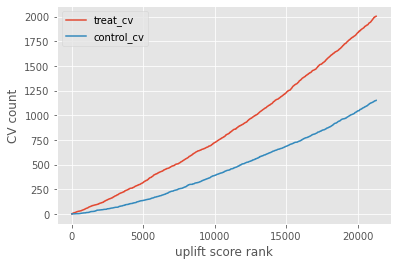

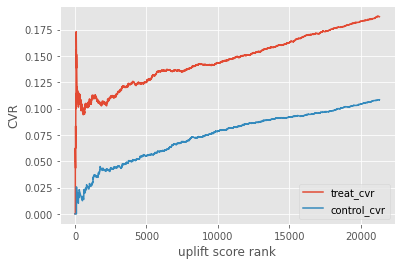

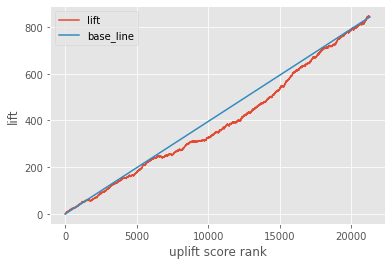

In [126]:
# 可視化

# uplift score rankとCV数
df.plot(y=["treat_cv", "control_cv"])
plt.xlabel("uplift score rank")
plt.ylabel("CV count")

# uplift score rankとCVR
df.plot(y=["treat_cvr", "control_cvr"])
plt.xlabel("uplift score rank")
plt.ylabel("CVR")

# uplift score rankとlift（ = uplift curve）
df.plot(y=["lift", "base_line"])
plt.xlabel("uplift score rank")
plt.ylabel("lift")

In [132]:
# AUUC算出
# AUUC = liftとbase_lineの間の領域の面積を正規化したもの（各uplift score rankにおけるliftとbase_lineの差の平均値）
auuc = (df["lift"] - df["base_line"]).sum() / len(df["lift"])
print(f"AUUC = {auuc}")

AUUC = -32.0862974060599


Text(0, 0.5, 'lift')

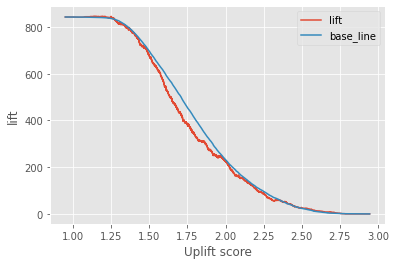

In [133]:
# uplift scoreとlift
df.plot(x="score", y=["lift", "base_line"])
plt.xlabel("Uplift score")
plt.ylabel("lift")